**ChronoNet** is a deep learning architecture designed specifically for EEG data. It was proposed by authors in a 2019 paper titled "ChronoNet: A Deep Recurrent Neural Network for Abnormal EEG Identification," which can be found here: https://arxiv.org/abs/1903.00754.

The ChronoNet model is a deep recurrent neural network (RNN) that uses a combination of convolutional and recurrent layers to process EEG data over time. It is designed to identify abnormal EEG patterns, which can be indicative of neurological disorders such as epilepsy.

The architecture of ChronoNet consists of three main components: a convolutional neural network (CNN) for feature extraction, a recurrent neural network (RNN) for temporal modeling, and a fully connected layer for classification. The CNN component consists of a series of convolutional layers with batch normalization and ReLU activation, followed by a max pooling layer and dropout regularization. The RNN component uses a Gated Recurrent Unit (GRU) layer to model temporal dependencies in the EEG data. The output of the RNN is fed into a fully connected layer with softmax activation for classification.

The authors of the paper evaluated the performance of ChronoNet on a dataset of EEG recordings from patients with epilepsy and demonstrated that it outperforms existing methods for abnormal EEG identification. They also showed that the model is robust to variations in the length of the input EEG signals and can effectively handle multi-channel EEG data.

Overall, ChronoNet is a powerful tool for analyzing EEG data and has the potential to improve the diagnosis and treatment of neurological disorders.

In [32]:
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GRU, Dense, Reshape
from tensorflow.keras.models import Model


# # Load the EEG signals and target labels
# X = np.load('eeg_signals')
# y = np.load('target_labels')

# # Convert target labels to one-hot encoding
# y = to_categorical(y)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ChronoNet-V1

In [33]:
# Define the model architecture
model = Sequential()

# Add the convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(32, 32)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add the max pooling layers
model.add(MaxPooling1D(pool_size=2, strides=2))

# Add the recurrent layers
model.add(LSTM(units=32, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(units=32, dropout=0.5, recurrent_dropout=0.5))

# Concatenate the output from the convolutional and recurrent layers
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 30, 32)            3104      
                                                                 
 conv1d_4 (Conv1D)           (None, 28, 32)            3104      
                                                                 
 conv1d_5 (Conv1D)           (None, 26, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 32)           0         
 1D)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 13, 32)            8320      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                      

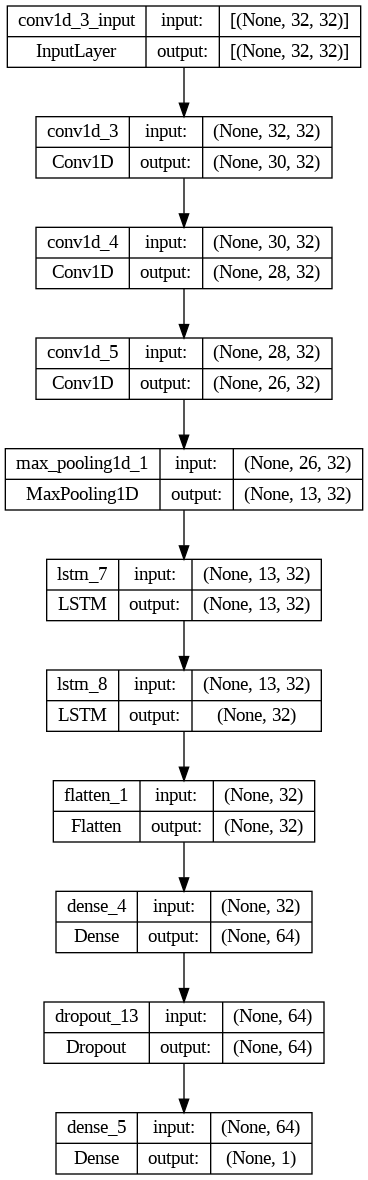

In [34]:
plot_model(model, to_file='ChronoNet-v1.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the testing set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

## ChronoNet-V2

Here is an implementation of ChronoNet for binary classification of EEG signals with 32 channels, fixed number of time steps (n_timesteps=32), and using sigmoid activation

In [35]:
def ChronoNet(input_shape=(32, 32, 1)):
  # Input layer
  X_input = Input(input_shape)

  # Convolutional layer
  X = Conv2D(8, (32, 1), strides=(4, 1), padding='same', activation=None)(X_input)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2, 1), strides=(2, 1), padding='same')(X)
  X = Dropout(0.5)(X)
  # Reshape output of Convolutional layer to (batch_size, timesteps, input_dim)
  X = Reshape((-1, X.shape[2] * X.shape[3]))(X)

  # Recurrent layer
  X = GRU(16, return_sequences=True)(X)
  X = Dropout(0.5)(X)
  X = GRU(16)(X)
  X = Dropout(0.5)(X)

  # Output layer
  X = Dense(1, activation='sigmoid')(X)

  # Create model
  model = Model(inputs=X_input, outputs=X)

  return model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 8, 32, 8)          264       
                                                                 
 batch_normalization_33 (Bat  (None, 8, 32, 8)         32        
 chNormalization)                                                
                                                                 
 activation_33 (Activation)  (None, 8, 32, 8)          0         
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 4, 32, 8)         0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 4, 32, 8)          0   

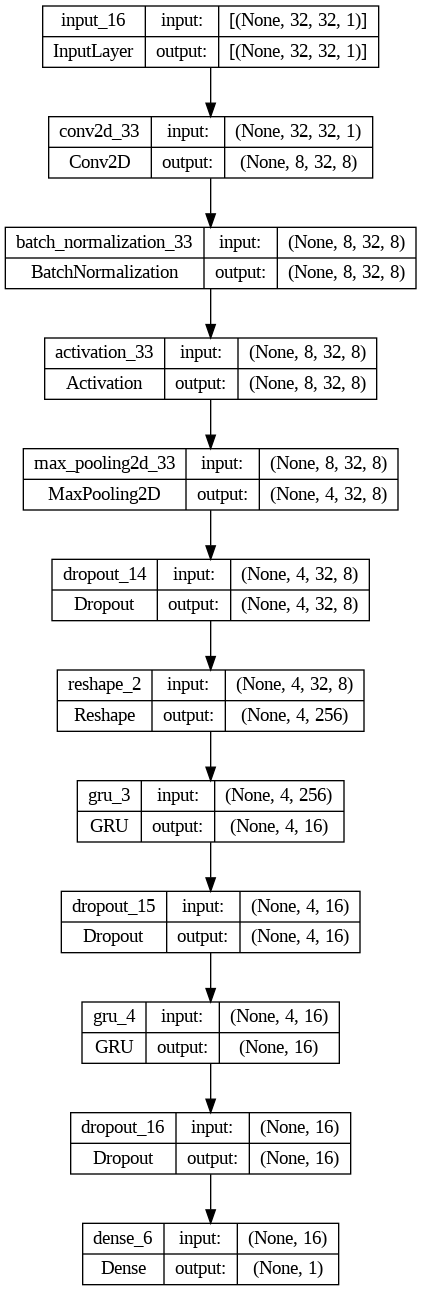

In [36]:
model = ChronoNet()
model.summary()
plot_model(model, to_file='ChronoNet-v2.png', show_shapes=True, show_layer_names=True)

The input x should have shape **(batch_size, 32, 32, 1)**, where **batch_size** is the number of samples in each batch, **32** is the number of EEG channels, **32** is the number of time steps in each sample, and **1** represents the number of input channels.

The target y should have shape **(batch_size, 1)**

In [ ]:
model = ChronoNet(input_shape=(32, 32, 1))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Assuming X_train and y_train are the training data
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

## ChronoNet-V3

In [37]:
def ChronoNet(input_shape=(32, None, 1)):
  # Input layer
  X_input = Input(input_shape)

  # Convolutional layer
  X = Conv2D(8, (32, 1), strides=(4, 1), padding='same', activation=None)(X_input)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2, 1), strides=(2, 1), padding='same')(X)
  X = Dropout(0.5)(X)

  # Reshape to convert to 3D tensor
  X = Reshape((-1, X.shape[2]*X.shape[3]))(X)

  # Recurrent layer
  X = LSTM(16, return_sequences=True)(X)
  X = Dropout(0.5)(X)
  X = LSTM(16)(X)
  X = Dropout(0.5)(X)

  # Output layer
  X = Dense(1, activation='sigmoid')(X)

  # Create model
  model = Model(inputs=X_input, outputs=X)

  return model

This model is similar to the previous one, **but replaces the GRU layers with LSTM layers**, and uses variable time steps (i.e., None for the second dimension of the input shape). The input x should have shape **(batch_size, 32, n_timesteps, 1)**

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 8, 32, 8)          264       
                                                                 
 batch_normalization_34 (Bat  (None, 8, 32, 8)         32        
 chNormalization)                                                
                                                                 
 activation_34 (Activation)  (None, 8, 32, 8)          0         
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 4, 32, 8)         0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 4, 32, 8)          0   

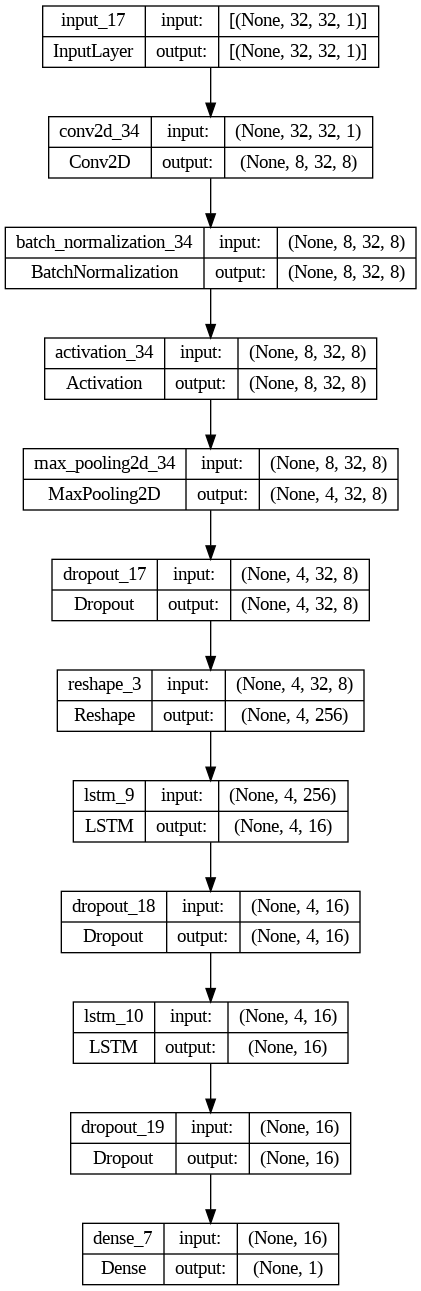

In [38]:
model = ChronoNet(input_shape=(32, 32, 1))
model.summary()
plot_model(model, to_file='ChronoNet-v3.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Assuming X_train and y_train are the training data
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))